# REINFORCE (Vanilla Policy Gradients)

In this notebook we will implementing REINFORCE algorithm on 2 environments : a) CartPole b) Lunar Landing. We will be using OpenAI's gym library to use these environments. Both of these environments have discrete action spaces, so we will have a softmax policy in both cases. Our Policy network will be a 2 layer fully connected neural net with ReLU activation for the hidden layer.

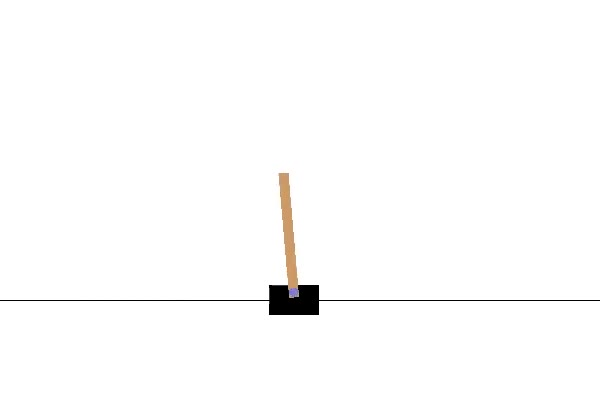

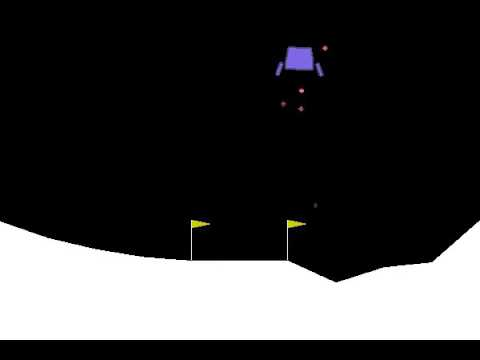

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import gym
import matplotlib.pyplot as plt
import time

## Gym

OpenAI's gym package provides a wide variety of environments to train reinforcement learning agents on. The environments can be broadly classified into 6 categories:

- Atari : Breakout, Pong etc.
- Box2D : Lunar Lander, Car Racing etc.
- Classic Control : Cart Pole, Acrobat etc.
- MuJoCo : Half Cheetah, Walker etc.
- Robotics : Fetch Pick And Place, Fetch And Push etc.
- Toy text : Black Jack, Frozen Lake

In [2]:
# A gym environment can be initialize by using make method of gym.
env = gym.make('CartPole-v0')

In [3]:
# Each environment will have observation_space and action_space as instance fields.
# Continuous spaces are of type Box, and discrete spaces are of type DISCRETE.
print(env.observation_space)
print(env.action_space)

Box(4,)
Discrete(2)


In [4]:
# To begin with the initial state, reset() method is used
state = env.reset()
print(state)

[ 0.02264221  0.04307462  0.01336899 -0.02014084]


In [5]:
# To interact with the environment by taking an action, step() method is used.
# It executes that action in environment and returns the new state and the reward.
new_state, reward, done, _ = env.step(env.action_space.sample()) # select a random action
print(new_state)
print(reward)
print(done)

[ 0.0235037   0.23800232  0.01296618 -0.30857589]
1.0
False


## Policy Network

In [6]:
class PolicyNet(nn.Module):
    
    def __init__(self, obs_dim, act_dim, hidden_size = 64):
        '''
        Initializing a 2 layer neural net
        '''
        super(PolicyNet, self).__init__()
        self.policy = nn.Sequential(
                        nn.Linear(obs_dim, hidden_size),
                        nn.ReLU(),
                        nn.Linear(hidden_size, act_dim),
                        nn.Softmax(dim = -1)
                    )
        
    def forward(self, x):
        '''
        Input:
            -x : A tensor of shape [batch_size, obs_dim] representing the state
        
        Returns a tensor of shape [batch_size, act_dim] representing the probability of taking each action
        '''
        return self.policy(x)

In [16]:
env = gym.make('CartPole-v0')

In [17]:
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n

In [18]:
net = PolicyNet(obs_dim, act_dim)

In [19]:
print(net)

PolicyNet(
  (policy): Sequential(
    (0): Linear(in_features=4, out_features=64, bias=True)
    (1): ReLU()
    (2): Linear(in_features=64, out_features=2, bias=True)
    (3): Softmax()
  )
)


In [12]:
opti = optim.Adam(net.parameters(), lr = 0.01)

## Training RL algent using REINFORCE

In [13]:
def find_q_vals(rewards, gamma):
    
    '''
    This function computes the returns from the rewards observed in an episode.
    
    Inputs:
        - rewards : List of rewards encountered in an episode [len_episode]
        - gamma : Discount factor
    
    Returns an numpy array containing returns at each time step in an episode
    '''
    
    q_vals = np.zeros(len(rewards))
    q_vals[-1] = rewards[-1]
    
    for i in reversed(range(len(rewards)-1)):
        q_vals[i] = rewards[i] + gamma*q_vals[i+1]
        
    return q_vals

In [14]:
def REINFORCE(env, net, opti, num_trajs = 4, num_runs = 200, gamma = 0.99, print_every = 1):
    '''
    Trains the RL agent using REINFORCE algorithm.
    
    Inputs:
        - env : Environment Instance
        - net : Policy network
        - opti : Optimizer to train the network
        - num_trajs : Number of trajectories to collect before making and update to the policy
        - num_runs : Total number of gradient updates
        - gamma : Discount factor
        - print_every : Iterations after which reward stats are to be printed
        
    Returns a list containing the mean returns 
    '''
    running_return = 0
    running_returns = []
    ep = 0
    
    for _ in range(num_runs):
        surr_loss = 0
        opti.zero_grad()
        
        for _ in range(num_trajs):
            rewards, logps = [], []
            state = env.reset()
            
            while True:
                state_v = torch.FloatTensor(state).unsqueeze(0)
                p_v = net(state_v)
                p = p_v.detach().numpy().squeeze()
                action = np.random.choice(np.arange(act_dim), p = p)
                state, reward, done, _ = env.step(action)
                
                rewards.append(reward)
                logps.append(torch.log(p_v)[:1, action])
                if done:
                    break
                    
            running_return = 0.1*sum(rewards) + 0.9*running_return
            running_returns.append(running_return)
            
            if (ep+1)%print_every == 0:
                print("Episode {} completed, total reward {}, mean return {}".format(ep+1, sum(rewards), np.round(running_return,2)))
            
            q_vals = find_q_vals(rewards, gamma)
            q_vals_v = torch.FloatTensor(q_vals)
            logps_v = torch.cat(logps, dim = 0)
            surr_loss += torch.sum(-logps_v*q_vals_v)
            ep += 1
        
        surr_loss = surr_loss/num_trajs
        surr_loss.backward()
        opti.step()
    
    return running_returns

In [77]:
returns = REINFORCE(env, net, opti, num_runs= 100)

Episode 1 completed, total reward 24.0, mean return 2.4
Episode 2 completed, total reward 18.0, mean return 3.96
Episode 3 completed, total reward 21.0, mean return 5.66
Episode 4 completed, total reward 39.0, mean return 9.0
Episode 5 completed, total reward 16.0, mean return 9.7
Episode 6 completed, total reward 17.0, mean return 10.43
Episode 7 completed, total reward 24.0, mean return 11.79
Episode 8 completed, total reward 31.0, mean return 13.71
Episode 9 completed, total reward 45.0, mean return 16.84
Episode 10 completed, total reward 28.0, mean return 17.95
Episode 11 completed, total reward 17.0, mean return 17.86
Episode 12 completed, total reward 18.0, mean return 17.87
Episode 13 completed, total reward 130.0, mean return 29.08
Episode 14 completed, total reward 45.0, mean return 30.68
Episode 15 completed, total reward 49.0, mean return 32.51
Episode 16 completed, total reward 100.0, mean return 39.26
Episode 17 completed, total reward 83.0, mean return 43.63
Episode 18 c

Episode 144 completed, total reward 191.0, mean return 157.97
Episode 145 completed, total reward 194.0, mean return 161.57
Episode 146 completed, total reward 200.0, mean return 165.41
Episode 147 completed, total reward 107.0, mean return 159.57
Episode 148 completed, total reward 200.0, mean return 163.61
Episode 149 completed, total reward 200.0, mean return 167.25
Episode 150 completed, total reward 200.0, mean return 170.53
Episode 151 completed, total reward 134.0, mean return 166.87
Episode 152 completed, total reward 200.0, mean return 170.19
Episode 153 completed, total reward 200.0, mean return 173.17
Episode 154 completed, total reward 200.0, mean return 175.85
Episode 155 completed, total reward 153.0, mean return 173.57
Episode 156 completed, total reward 200.0, mean return 176.21
Episode 157 completed, total reward 181.0, mean return 176.69
Episode 158 completed, total reward 200.0, mean return 179.02
Episode 159 completed, total reward 200.0, mean return 181.12
Episode 

Episode 280 completed, total reward 200.0, mean return 183.5
Episode 281 completed, total reward 200.0, mean return 185.15
Episode 282 completed, total reward 200.0, mean return 186.63
Episode 283 completed, total reward 111.0, mean return 179.07
Episode 284 completed, total reward 200.0, mean return 181.16
Episode 285 completed, total reward 200.0, mean return 183.05
Episode 286 completed, total reward 90.0, mean return 173.74
Episode 287 completed, total reward 58.0, mean return 162.17
Episode 288 completed, total reward 200.0, mean return 165.95
Episode 289 completed, total reward 200.0, mean return 169.36
Episode 290 completed, total reward 145.0, mean return 166.92
Episode 291 completed, total reward 165.0, mean return 166.73
Episode 292 completed, total reward 200.0, mean return 170.06
Episode 293 completed, total reward 200.0, mean return 173.05
Episode 294 completed, total reward 200.0, mean return 175.75
Episode 295 completed, total reward 200.0, mean return 178.17
Episode 296

Text(0,0.5,'Mean reward')

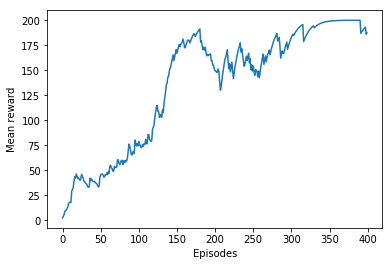

In [78]:
plt.plot(returns)
plt.xlabel("Episodes")
plt.ylabel("Mean reward")

In [21]:
net.load_state_dict(torch.load('Policies/CartPole.dat'))

## Testing the agent

In [22]:
for i in range(1):
    state = env.reset()
    while True:
        env.render()
        time.sleep(.03)
        state_v = torch.FloatTensor(state).unsqueeze(0)
        p_v = net(state_v)
        p = p_v.detach().numpy().squeeze()
        action = np.argmax(p)
        state, reward, done, _ = env.step(action)
        if done:
            break

## Training the agent for Lunar Lander environment

In [7]:
env = gym.make('LunarLander-v2')

In [8]:
obs_dim = env.observation_space.shape[0]
act_dim = env.action_space.n

In [9]:
print(obs_dim)
print(act_dim)

8
4


In [10]:
net = PolicyNet(obs_dim, act_dim, hidden_size=64)

In [23]:
opti = optim.Adam(net.parameters(), lr = 0.01)

In [13]:
returns = REINFORCE(env, net, opti, num_trajs=100, print_every= 100)

Episode 100 completed, total reward -115.2873395088834, mean return -176.49
Episode 200 completed, total reward -143.51729322628285, mean return -209.34
Episode 300 completed, total reward -186.1037070225421, mean return -154.94
Episode 400 completed, total reward -55.71623368175675, mean return -217.03
Episode 500 completed, total reward -81.74267018284806, mean return -138.33
Episode 600 completed, total reward -341.4488833350025, mean return -226.85
Episode 700 completed, total reward -85.99272357562822, mean return -145.43
Episode 800 completed, total reward -109.15649114465546, mean return -136.48
Episode 900 completed, total reward -97.89186805725656, mean return -120.4
Episode 1000 completed, total reward -32.95751069731415, mean return -120.97
Episode 1100 completed, total reward -126.76555766516344, mean return -149.91
Episode 1200 completed, total reward -116.95225298757015, mean return -133.81
Episode 1300 completed, total reward -106.79301240513888, mean return -110.46
Epis

Episode 11000 completed, total reward 258.4157618276004, mean return 227.42
Episode 11100 completed, total reward 268.6644157557035, mean return 244.74
Episode 11200 completed, total reward 15.994919923992015, mean return 172.39
Episode 11300 completed, total reward 238.35800218263824, mean return 240.35
Episode 11400 completed, total reward 87.9139622223596, mean return 237.77
Episode 11500 completed, total reward 287.8468080192732, mean return 251.8
Episode 11600 completed, total reward 213.51524941309233, mean return 229.12
Episode 11700 completed, total reward 228.5242756152664, mean return 242.27
Episode 11800 completed, total reward 251.1043610001909, mean return 233.77
Episode 11900 completed, total reward 271.3661550924058, mean return 233.58
Episode 12000 completed, total reward 244.9425292404007, mean return 254.31
Episode 12100 completed, total reward 265.3259081769062, mean return 260.1
Episode 12200 completed, total reward 278.6254402512278, mean return 242.82
Episode 1230

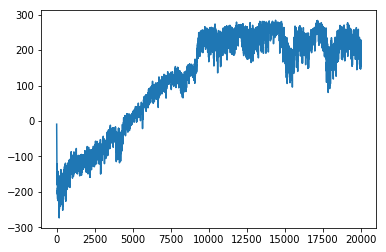

In [39]:
plt.plot(returns)

In [14]:
net.load_state_dict(torch.load('Policies/LunarLander.dat'))

In [15]:
for i in range(1):
    state = env.reset()
    rewards = []
    while True:
        env.render()
        time.sleep(.03)
        state_v = torch.FloatTensor(state).unsqueeze(0)
        p_v = net(state_v)
        p = p_v.detach().numpy().squeeze()
        action = np.argmax(p)
        state, reward, done, _ = env.step(action)
        rewards.append(reward)
        if done:
            break

In [13]:
sum(rewards)

-700.5969779549818